In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import scipy.interpolate
import pyproj
import os

This is a quick reference (mostly written for myself) for loading a few common NetCDF-format continent-wide Antarctic datasets. This notebook will produce these plots:

![MEaSURE Velocities](surfacevelocity.png) ![Surface Mass Balances](smb.png) ![BedMachine Ice Thicknesses](bedmachinethickness.png)

## Loading common NetCDF-format Antarctic datasets in Python

If you're a MATLAB user, Antarctic Mapping Tools provides easy access to this sort of data. Unfortunatley, no equivalent exists (to my knowledge) for other langauges.

https://www.mathworks.com/matlabcentral/fileexchange/47638-antarctic-mapping-tools

This is mostly meant as a reference for myself, but hopefully it'll be helpful to others too. Below are simple examples of how to load three common Antarctic datasets:

* MEaSUREs InSAR Surface Velocities

  https://nsidc.org/data/NSIDC-0754/versions/1
  
  InSAR-dervied surface velocities across Antarctica at a spatial resolution of 450 m.
  
* BedMachine Antarctica Basal Topography

  https://nsidc.org/data/NSIDC-0756/versions/1
  
  Basal topography at a 500 m resolution inferred from a variety of methods, including mass conservation in fast-flowing areas.
  
* RACMO3.2p2 Modelled Surface Mass Balances

  https://www.projects.science.uu.nl/iceclimate/publications/data/2018/vwessem2018_tc/RACMO_Yearly/
  https://tc.copernicus.org/articles/12/1479/2018/
  
  Estimated surface mass balances based on the RACMO3.2p2 climate model. **Use caution with the units here. See notes below and also:**
  
  https://www.nature.com/articles/nature24478.pdf

In [2]:
data_dir = '/home/thomas/Downloads/' # don't do this :p

nc_measure = Dataset(os.path.join(data_dir, 'antarctica_ice_velocity_450m_v2.nc'))
nc_bedmachine = Dataset(os.path.join(data_dir, 'BedMachineAntarctica_2019-11-05_v01.nc'))
nc_smb_racmo = Dataset(os.path.join(data_dir, 'SMB_RACMO2.3p2_yearly_ANT27_1979_2016.nc'))

Each of these `Dataset`s is annotated with information about the various fields. You can see all of the field sizes and metadata like this:

> `nc_measure.variables`

For example, the `VX` field of the MEaSURE dataset looks like this:

> ```
'VY': <class 'netCDF4._netCDF4.Variable'>
 float32 VY(y, x)
     long_name: Ice velocity in y direction
     standard_name: land_ice_y_velocity
     units: meter/year
     _FillValue: 0.0
     coordinates: lon lat
     grid_mapping: coord_system
 unlimited dimensions: 
 current shape = (12445, 12445)
 filling on,
 ```

In [3]:
#nc_measure.variables

### Plotting MEaSURE data

The MEaSURE dataset has three 2D variables we can load containing latitudes, longitudes, and two orthogonal components of the the ice surface velocity. Plotting this data requires loading the data, projecting the latitudes and longitudes onto the map space, and interpolating the data onto a grid for plotting.

The interpolation is needed here because it's much more efficient to plot data on a regular grid in the map projection. In order to guarentee that the data ends up on a uniform grid in the map projection, we'll take the approach of re-interpolating all of the data here. Depending on your application, you may not need to do this.

Because this data is quite dense and we don't have all day, we're going to decimate it by a factor of 50 (i.e. take only every 50th sample) when we load it. If you're using the data for anything other than a quick map, you probably shouldn't do this.

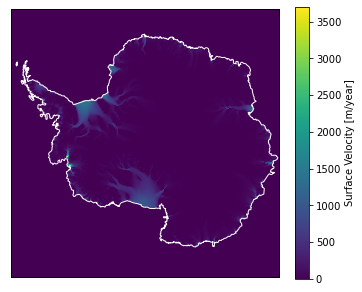

In [4]:
# Make the plot
boundinglat = -65
lon_0 = 180
plt.figure(figsize=(6,5), facecolor='white')
m = Basemap(projection='spstere',boundinglat=boundinglat,lon_0=lon_0,resolution='l')
m.drawcoastlines(color='white')
m.drawmapboundary()

# Interpolate data to a grid
n = 50 # We'll decimate the input data to make it faster to plot
lat_measure = (np.array(nc_measure.variables['lat']))[::n,::n]
lon_measure = (np.array(nc_measure.variables['lon']))[::n,::n]
vx_measure = (np.array(nc_measure.variables['VX']))[::n,::n]
vy_measure = (np.array(nc_measure.variables['VY']))[::n,::n]

v_mag_measure = np.sqrt(vx_measure**2 + vy_measure**2) # Magnitude of velocity

xs_measure, ys_measure = m(lon_measure, lat_measure)

xgrid, ygrid = np.mgrid[np.min(xs_measure):np.max(xs_measure):10000, np.min(ys_measure):np.max(ys_measure):10000] # Create the map grid

v_mag_grid = scipy.interpolate.griddata((xs_measure.flatten(), ys_measure.flatten()), v_mag_measure.flatten(), (xgrid, ygrid))

# Plot data
m.pcolormesh(xgrid, ygrid, v_mag_grid)

clb = plt.colorbar()
clb.set_label('Surface Velocity [m/year]')

#plt.savefig('surfacevelocity.png')

plt.show()

### Plotting RACMO data

The RACMO data comes in pretty much the same format, so there's not much different here. One note is that this dataset contains details for multiple years. For our purposes, we'll average across the years.

Another very important note is that the units in the surface mass balance dataset appear to be incorrect. The metadata gives units of `kg m-2 s-1`, however these numbers don't make sense. Treating this variable as if it had a unit of kilograms per meter squared per **year** produces values that make sense.

For the plot below, we divide this number by 900 kg / m^3 to produce an approximate ice-equivalent thickness change from surface mass balance.

In [5]:
nc_smb_racmo.variables['smb'] # Note the 'units' field here

<class 'netCDF4._netCDF4.Variable'>
float32 smb(time, height, rlat, rlon)
    _FillValue: -9999.0
    cell_methods: time: 24-hr averaged values
    coordinates: lon lat
    grid_mapping: rotated_pole
    long_name:  Surface Mass Balance ice sheet
    standard_name: smb
    units: kg m-2 s-1
unlimited dimensions: time
current shape = (38, 1, 240, 262)
filling on

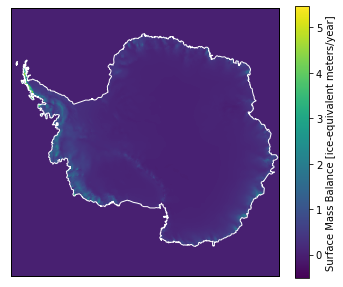

In [6]:
# Make the plot
boundinglat = -65
lon_0 = 180
plt.figure(figsize=(6,5), facecolor='white')
m = Basemap(projection='spstere',boundinglat=boundinglat,lon_0=lon_0,resolution='l')
m.drawcoastlines(color='white')
m.drawmapboundary()

# Interpolate data to a grid
lat_racmo = np.array(nc_smb_racmo.variables['lat'])
lon_racmo = np.array(nc_smb_racmo.variables['lon'])
smb_racmo = np.array(nc_smb_racmo.variables['smb'])
smb_racmo_avg = np.mean(smb_racmo[:,0,:,:], axis=0) # Time average over all years in the dataset

xs_racmo, ys_racmo = m(lon_racmo, lat_racmo)

smc_grid = scipy.interpolate.griddata((xs_racmo.flatten(), ys_racmo.flatten()), smb_racmo_avg.flatten() / 900, (xgrid, ygrid))

# Plot data
m.pcolormesh(xgrid, ygrid, smc_grid)

clb = plt.colorbar()
clb.set_label('Surface Mass Balance [ice-equivalent meters/year]')

#plt.savefig('smb.png')

plt.show()

### Plotting BedMachine data

The MEaSURE and RACMO datasets both have latitutde/longitude coordinates associated with each datapoint. The BedMachine dataset only provides coordinates in a polar stereographic projection. Specifically, from the BedMachine data website:

> "The projection is Polar Stereographic South (71ºS, 0ºE), which corresponds to ESPG 3031"
> https://sites.uci.edu/morlighem/dataproducts/bedmachine-antarctica/

We can use `PyProj` to convert between these. To do this, we first define the two coordinate reference systems. Then, we create a `Transformer` to project from one to the other.

A somewhat circuitous but easy approach is to convert everything back to latitudes and longitudes and then follow our prior approach.

In [7]:
crs_latlon = pyproj.crs.CRS.from_proj4("+proj=latlon")
crs_epsg3031 = pyproj.crs.CRS.from_epsg(3031)
transformer = pyproj.Transformer.from_crs(crs_epsg3031, crs_latlon)

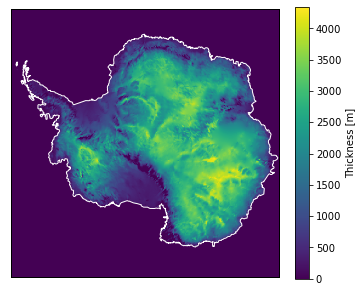

In [8]:
# Make the plot
boundinglat = -65
lon_0 = 180
plt.figure(figsize=(6,5), facecolor='white')
m = Basemap(projection='spstere',boundinglat=boundinglat,lon_0=lon_0,resolution='l')
m.drawcoastlines(color='white')
m.drawmapboundary()

# Interpolate data to a grid
n = 50 # We'll decimate the input data to make it faster to plot
x_bm = (np.array(nc_bedmachine.variables['x']))[::n]
y_bm = (np.array(nc_bedmachine.variables['y']))[::n]
thickness_bm = (np.array(nc_bedmachine.variables['thickness']))[::n,::n]

X_bm, Y_bm = np.meshgrid(x_bm, y_bm)
lon_bm, lat_bm = transformer.transform(X_bm, Y_bm)

xs_bm, ys_bm = m(lon_bm, lat_bm)

thickness_grid = scipy.interpolate.griddata((xs_bm.flatten(), ys_bm.flatten()), thickness_bm.flatten(), (xgrid, ygrid))

# Plot data
m.pcolormesh(xgrid, ygrid, thickness_grid)

clb = plt.colorbar()
clb.set_label('Thickness [m]')

#plt.savefig('bedmachinethickness.png')

plt.show()